In [1]:
!pip install micrograd

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph

In [28]:
class Value:

  def __init__(self,data, _children=(), _op='', label=''):
    self.data=data
    self.grad=0.0
    self._backward = lambda: None
    self._prev=set(_children)
    self._op=_op
    self.label=label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self,other):
    out=Value(self.data+other.data,(self,other),'+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self,other):
    out=Value(self.data*other.data,(self,other),'*')

    def _backward():
      self.grad += other.data*out.grad
      other.grad += self.data*out.grad
    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t, (self, ) , 'tanh')

    def _backward():
      self.grad += (1-t**2) * out.grad

    out._backward=_backward
    return out

  def backward(self):
    topo=[]
    visited=set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad=1.0
    for node in reversed(topo):
      node._backward()

In [4]:
def trace(root):
  #set of all nodes and edges
  nodes,edges =set(),set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes,edges


def draw_dot(root):
  dot=Digraph(format='svg', graph_attr={'rankdir':'LR'})

  nodes,edges=trace(root)
  for n in nodes:
    uid=str(id(n))
    dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name=uid+n._op, label=n._op)
      dot.edge(uid+n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2))+n2._op)

  return dot

In [20]:
def lol():
  h=0.001
  a=Value(2.0, label='a')
  b=Value(-3.0, label='b')
  c=Value(10.0, label='c')
  e=a*b; e.label='e'
  d=e+c; d.label='d'
  f=Value(-2.0, label='f')
  L= d*f;L.label='L'
  L1=L.data

  a=Value(2.0, label='a')
  b=Value(-3.0, label='b')
  c=Value(10.0, label='c')
  e=a*b; e.label='e'
  d=e+c; d.label='d'
  f=Value(-2.0, label='f')
  L= d*f;L.label='L'
  L2=L.data+h

  print((L2-L1)/h)

lol()

1.000000000000334


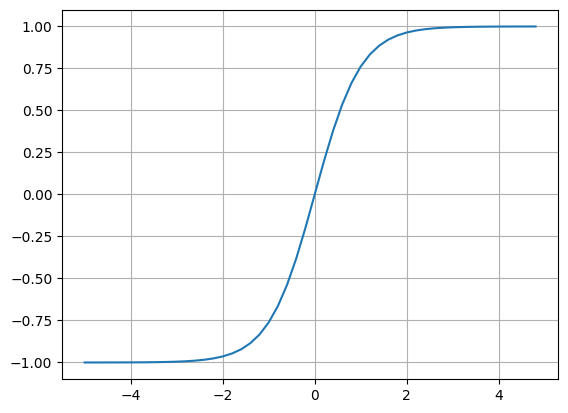

In [6]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [7]:
# inputs
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
#weights
w1 = Value(-3.0,label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.88137, label='b')

x1w1=x1*w1;x1w1.label='x1w1'
x2w2=x2*w2;x2w2.label='x2w2';
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1w1 + x2w2'
n=x1w1x2w2+b; n.label='n'
o = n.tanh(); o.label='o'

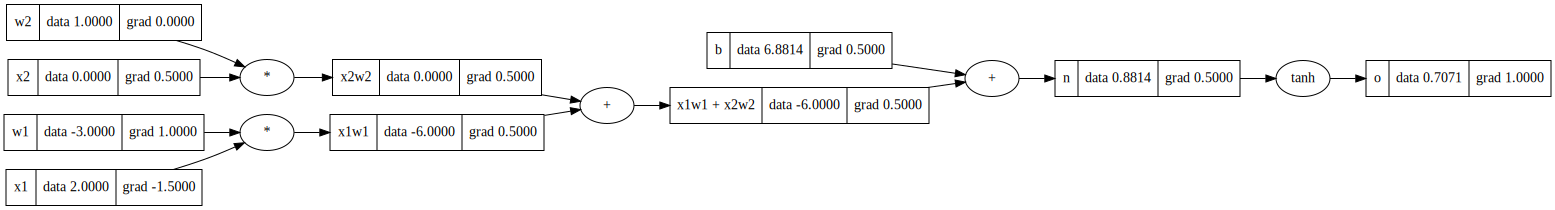

In [21]:
draw_dot(o)

In [9]:
o.backward()

In [10]:
o._backward()

In [11]:
n._backward()

In [12]:
b._backward()

In [13]:
x1w1x2w2._backward()

In [14]:
x2w2._backward()
x1w1._backward()

In [15]:
x2.grad=w2.data*x2w2.grad
w2.grad=x2.data*x2w2.grad

x1.grad=w1.data*x1w1.grad
w1.grad=x1.data*x1w1.grad

In [16]:
n.grad=0.5
x1w1x2w2.grad=0.5
b.grad=0.5
x1w1.grad=0.5
x2w2.grad=0.5

In [17]:
o.grad=1.0


In [18]:
1-o.data**2

0.5000025364090595

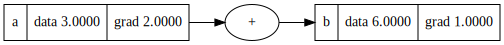

In [25]:
a=Value(3.0, label = 'a')
b = a + a ; b.label='b'
b.backward()
draw_dot(b)

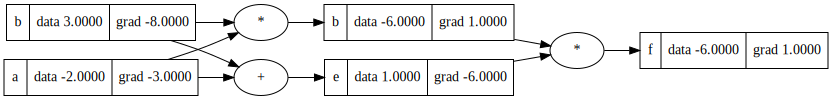

In [29]:
a = Value(-2.0,label = 'a')
b = Value(3.0, label = 'b')
d = a*b ; d.label= 'b'
e = a + b ; e.label = 'e'
f = d* e ; f.label = 'f'

f.backward()
draw_dot(f)